# Notebook de Regressão — Previsão de Custos de Nuvem  
## Projeto: Trilha A – Dados & IA (2ª parte: Modelo de ML)

Este notebook documenta, passo a passo, a segunda parte do projeto: a construção de um **pipeline de Machine Learning** para **prever custos de nuvem** a partir de dados públicos (ex.: AWS, Azure, GCP).  
Ele complementa a primeira parte (ingestão e processamento) e entrega:
- Código-fonte comentado
- Notebook com explicação do pipeline
- Gráficos e métricas do modelo
- Geração de arquivo `.csv` com previsões e erros


## 1) Bibliotecas e organização do ambiente

Aqui importamos as dependências para:
- manipulação de dados (`pandas`, `numpy`),
- pré-processamento (one-hot encoding, `ColumnTransformer`),
- modelagem (regressor linear básico e opção de XGBoost),
- avaliação (MAE, RMSE, R²),
- e separação treino/teste.


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor


## 2) Carregar os dados tratados

Carregamos o `.csv` **já processado** na etapa de ingestão/limpeza. Em seguida, fazemos uma checagem rápida do *head* para validar o schema e o conteúdo.


In [43]:
# Carregar o CSV tratado
df = pd.read_csv("cloud_pricing_processed.csv")

# Visualizar rapidamente
df.head()


,name,series,family,location,region,vCpus,memoryGB,hour,hourSpot,month,monthSpot,cost_per_vcpu_hour,cost_per_gb_hour
0,c4-highcpu-16,c4,General-purpose,africa,africa-south1,16.0,32.0,0.889984,0.355985,649.688413,259.869254,0.055624,0.027812
1,c4-highcpu-192,c4,General-purpose,africa,africa-south1,192.0,384.0,10.679810,4.271823,7796.260961,3118.431053,0.055624,0.027812
2,c4-highcpu-2,c4,General-purpose,africa,africa-south1,2.0,4.0,0.111248,0.044498,81.211052,32.483657,0.055624,0.027812
3,c4-highcpu-24,c4,General-purpose,africa,africa-south1,24.0,48.0,1.334976,0.533978,974.532620,389.803882,0.055624,0.027812
4,c4-highcpu-32,c4,General-purpose,africa,africa-south1,32.0,64.0,1.779968,0.711971,1299.376827,519.738509,0.055624,0.027812


## 3) Definir **target** e **features**

Nesta etapa:
- Escolhemos a variável **alvo** (custo/preço a ser previsto). Exemplos comuns: `costUSD`, `price`, `hourlyCost`, `monthlyCost`.
- Selecionamos **features** relevantes. Ex.: capacidade de CPU e memória, família/tipo de instância, região/zona.


In [44]:
# Target (variável que queremos prever)
y = df["cost_per_vcpu_hour"]

# Features preditoras
X = df[["vCpus", "memoryGB", "family", "region", "location"]]


## 4) Pré-processamento com `ColumnTransformer`

Separação entre:
- **Numéricas** (passam direto — `passthrough`)
- **Categóricas** (codificadas via `OneHotEncoder`)

Usamos `handle_unknown="ignore"` no encoder para lidar com categorias novas que possam aparecer em dados futuros (evita erro na inferência).

In [45]:
# Separar colunas numéricas e categóricas
num_features = ["vCpus", "memoryGB"]
cat_features = ["family", "region", "location"]

# Criar transformador para one-hot nas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


## 5) Construção do **pipeline** do modelo

O pipeline encadeia o **pré-processamento** e o **regressor**.  
Começamos com `LinearRegression` como **baseline** por ser rápido e servir de referência.  


=== Regressão Linear ===
MAE: 0.01683
RMSE: 0.03553
R²: 0.60980


/tmp/ipykernel_34664/3735824171.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_coef_df, x="coef", y="feature", palette="viridis", ax=axes[1])


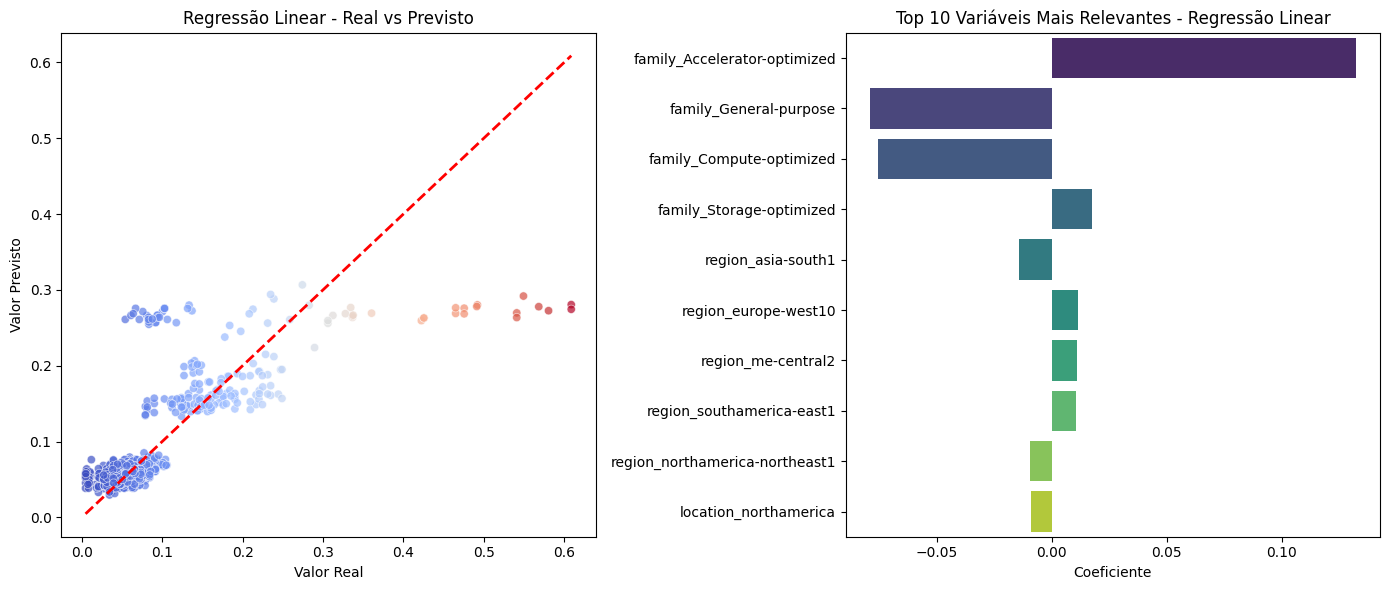

In [62]:
# ============================
# Regressão Linear com Pipeline
# ============================
lin_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

print("=== Regressão Linear ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_lin):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lin)):.5f}")
print(f"R²: {r2_score(y_test, y_pred_lin):.5f}")

# ===============================
# Regressão Linear - Comparação
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real vs Previsto
sns.scatterplot(x=y_test, y=y_pred_lin, hue=y_test, palette="coolwarm", alpha=0.7, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[0].set_title("Regressão Linear - Real vs Previsto")
axes[0].set_xlabel("Valor Real")
axes[0].set_ylabel("Valor Previsto")
axes[0].legend([],[], frameon=False)

# Importância das variáveis
top_coef_df = coef_df.head(10)
sns.barplot(data=top_coef_df, x="coef", y="feature", palette="viridis", ax=axes[1])
axes[1].set_title("Top 10 Variáveis Mais Relevantes - Regressão Linear")
axes[1].set_xlabel("Coeficiente")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()


=== XGBoost ===
MAE: 0.00541
RMSE: 0.00947
R²: 0.97230


/tmp/ipykernel_34664/2819547070.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_xgb_df, x="importance", y="feature", palette="mako", ax=axes[1])


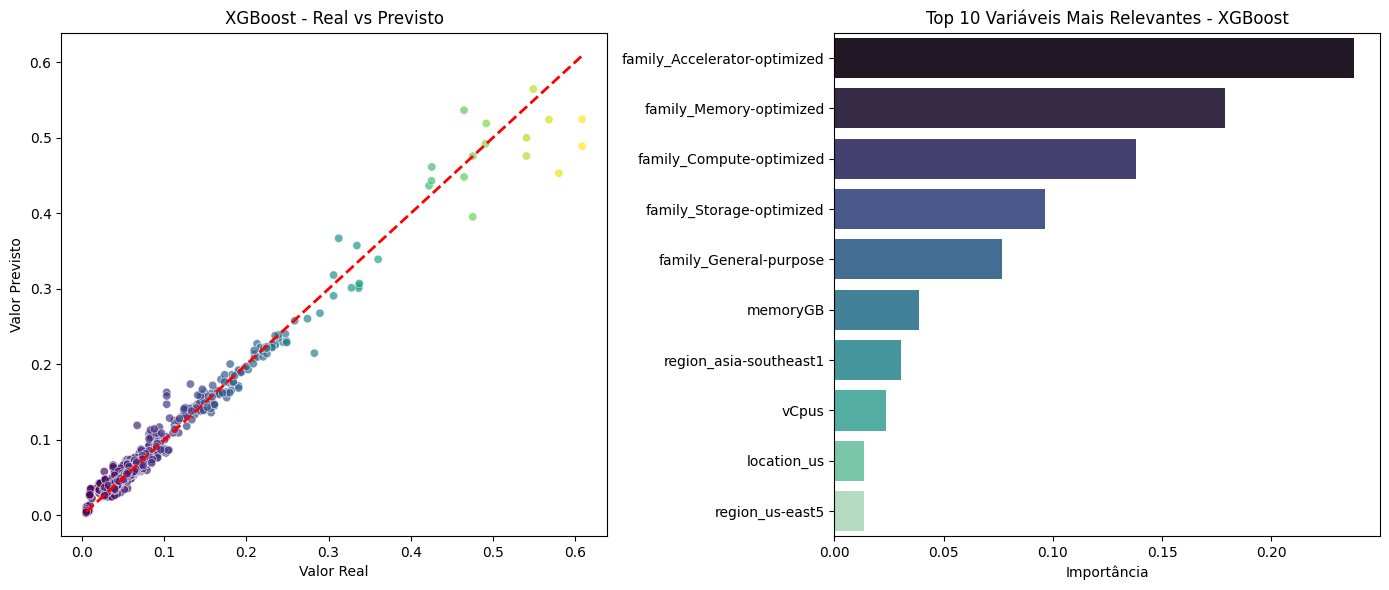

In [61]:
# ============================
# XGBoost
# ============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_transformed, y_train)
y_pred_xgb = xgb_model.predict(X_test_transformed)

print("\n=== XGBoost ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.5f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.5f}")
print(f"R²: {r2_score(y_test, y_pred_xgb):.5f}")

# ===============================
# XGBoost - Comparação
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real vs Previsto
sns.scatterplot(x=y_test, y=y_pred, hue=y_test, palette="viridis", alpha=0.7, ax=axes[0])
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[0].set_title("XGBoost - Real vs Previsto")
axes[0].set_xlabel("Valor Real")
axes[0].set_ylabel("Valor Previsto")
axes[0].legend([],[], frameon=False)  # remove legenda poluída

# Importância das variáveis
top_xgb_df = xgb_df.head(10)
sns.barplot(data=top_xgb_df, x="importance", y="feature", palette="mako", ax=axes[1])
axes[1].set_title("Top 10 Variáveis Mais Relevantes - XGBoost")
axes[1].set_xlabel("Importância")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

## 6) Treino, Validação e Avaliação dos Modelos

Após a preparação dos dados, o conjunto foi dividido em **treino (80%)** e **teste (20%)**.  
Foram testados dois modelos de regressão:

- **Regressão Linear** → modelo simples e interpretável, usado como *baseline*.  
- **XGBoost Regressor** → modelo de *gradient boosting*, mais robusto e capaz de capturar relações não lineares.

### Métricas de Avaliação
As métricas utilizadas foram:

- **MAE** (*Mean Absolute Error*) → erro absoluto médio; mede o erro médio em unidades do alvo.  
- **RMSE** (*Root Mean Squared Error*) → raiz do erro quadrático médio; penaliza mais fortemente erros grandes.  
- **R²** (*Coeficiente de Determinação*) → proporção da variância explicada; quanto mais próximo de 1, melhor o ajuste.  

**Resultados obtidos:**

| Modelo              | MAE     | RMSE    | R²     |
|----------------------|---------|---------|--------|
| Regressão Linear     | 0.01683 | 0.03553 | 0.6098 |
| XGBoost Regressor    | 0.00541 | 0.00947 | 0.9723 |

➡️ **Conclusão**: O XGBoost superou amplamente o baseline, explicando **97% da variância** dos custos e apresentando erros médios quase **3 vezes menores**.

### Visualizações
Foram produzidas as seguintes visualizações para apoiar a análise dos modelos:

- **Dispersão Real vs. Previsto** → quanto mais próximos os pontos estiverem da linha vermelha (45°), melhor a previsão.  
- **Resíduos vs. Valor Real** → erros centrados em 0 indicam ausência de viés sistemático.  
- **Importância das Variáveis** → destaca os atributos (família de instância, vCPUs, memória, região, etc.) que mais impactam no custo.

---

## 7) Interpretabilidade: Importância de Variáveis

Para compreender como cada atributo influencia os modelos, extraímos a importância das variáveis:

- **Regressão Linear**:  
  A contribuição é medida pelos **coeficientes**.  
  - Valores positivos indicam aumento no custo conforme a variável cresce.  
  - Valores negativos indicam efeito de redução.  
  - Como os dados categóricos foram transformados via *One-Hot Encoding*, cada categoria tem seu próprio peso no modelo.  

- **XGBoost**:  
  A importância é derivada da frequência e impacto das variáveis nas divisões das árvores.  
  - Valores maiores indicam que a feature contribui mais para reduzir o erro do modelo.  
  - Todas as importâncias são positivas, mas não representam diretamente o tamanho do impacto, apenas a relevância relativa.  

📊 **Top 10 variáveis mais influentes** foram destacadas nos gráficos, para focar nos fatores realmente determinantes no custo de nuvem.
